<a href="https://colab.research.google.com/github/Victor6b/lab454/blob/main/ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/My Drive/Intrusion-Detection-System-Using-CNN-and-Transfer-Learning'

/content/drive/My Drive/Intrusion-Detection-System-Using-CNN-and-Transfer-Learning


In [5]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

In [ ]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './test_Spark_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 1116 images belonging to 6 classes.


In [ ]:
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [ ]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}


In [ ]:
#read images from validation folder
rootdir = './test_Spark_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
if test_laels and test_images:
    print(test_laels[0], test_images[0])
else:
    print("No images found in the validation folder.")


0 ./test_Spark_224/0/25703.png


In [ ]:
 #load model 1: xception
xception_model=load_model('./xception.h5')

In [ ]:
 #load model 2: inception
incep_model=load_model('./inception.h5')

In [ ]:
 #load model 3: inceptionresnet
inres_model=load_model('./inceptionresnet.h5')

OSError: No file or directory found at ./inceptionresnet.h5

In [ ]:
 #load model 4: VGG19
vgg19_model=load_model('./VGG19.h5')

In [ ]:
 #load model 5: resnet
resnet_model=load_model('./resnet.h5')

In [ ]:
 #load model 1: DenseNet121
DenseNet121_model=load_model('./DenseNet121.h5')

In [ ]:
 #load model 1: MobileNet
MobileNet_model=load_model('./MobileNet.h5')

In [ ]:
 #load model 1: efficientnetB0
efficientnetB0_model=load_model('./efficientnetB0.h5')

#xception


1/1 [==============================] - 1s 748ms/step
Predicted result for the first image: 0
Confidence level: 1.0


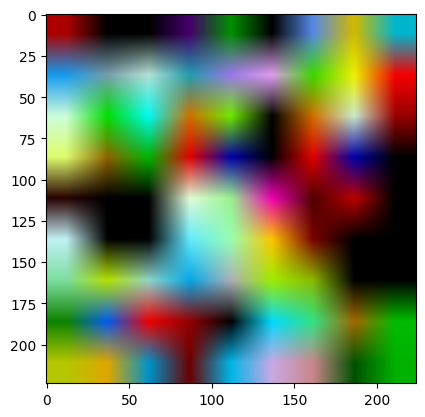

In [ ]:
#Single image prediction
import cv2
import matplotlib.pyplot as plt
test=cv2.imread(test_images[0])

img_show=test[:,:,[2,1,0]]
test=test/255.
test_shape=(1,)+test.shape
test=test.reshape(test_shape)

res=xception_model.predict(test)

prob=res[0,np.argmax(res,axis=1)[0]]
res=label[np.argmax(res,axis=1)[0]]
print('Predicted result for the first image: %s'%res)
print('Confidence level: %s'%prob)
plt.imshow(img_show)
plt.show()

In [ ]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    xception_model_batch=xception_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=xception_model_batch[0,np.argmax(xception_model_batch,axis=1)[0]]
    res=label[np.argmax(xception_model_batch,axis=1)[0]]
    predict.append(res)


1/1 [==============================] - 0s 24ms/step
CPU times: user 42.6 s, sys: 1.49 s, total: 44.1 s
Wall time: 48.7 s


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('Xception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

Xception accuracy: 0.9210526315789473
precision: 0.8483379501385042
recall: 0.9210526315789473
f1: 0.8832011535688535
[[490   0]
 [ 42   0]]


ValueError: Number of classes, 2, does not match size of target_names, 5. Try specifying the labels parameter

#原esemble


In [ ]:
import time
from PIL import Image
import tensorflow as tf

predict = []
length = len(test_images)
t1 = time.time()
expected_shape = (224, 224, 3)

for i in range((length // 127) + 1):
    input_img = test_images[127 * i: 127 * (i + 1)]
    test_batch = []

    for path in input_img:
        this_img = np.array(Image.open(path)) / 255

        test_batch.append(this_img)

    test_batch = np.array(test_batch)
    # generate result by model 1
    xception_model_batch = xception_model.predict(test_batch)
    xception_model_batch = list(np.argmax(xception_model_batch, axis=1))
    xception_model_batch = [label[con] for con in xception_model_batch]

    # generate result by model 2
    #DenseNet121_model_batch = DenseNet121_model.predict(test_batch)
    #DenseNet121_model_batch = list(np.argmax(DenseNet121_model_batch, axis=1))
    #DenseNet121_model_batch = [label[con] for con in DenseNet121_model_batch]

    # generate result by model 3
    MobileNet_model_batch =MobileNet_model.predict(np.array(test_batch))
    MobileNet_model_batch = list(np.argmax(MobileNet_model_batch, axis=1))
    MobileNet_model_batch = [label[con] for con in MobileNet_model_batch]

    # generate result by model 4
    incep_model_batch = incep_model.predict(test_batch)
    incep_model_batch = list(np.argmax(incep_model_batch, axis=1))
    incep_model_batch = [label[con] for con in incep_model_batch]

    # generate result by model 4
  #  efficientnetB0_model_batch = efficientnetB0_model.predict(test_batch)
   # efficientnetB0_model_batch = list(np.argmax(efficientnetB0_model_batch, axis=1))
   # efficientnetB0_model_batch = [label[con] for con in efficientnetB0_model_batch]

    # generate result by model 5
    #inres_model_batch = inres_model.predict(test_batch)
    #inres_model_batch = list(np.argmax(inres_model_batch, axis=1))
    #inres_model_batch = [label[con] for con in inres_model_batch]

    # bagging the three results generated by 3 singular models
    predict_batch = []

    for i, j, k in zip(xception_model_batch, incep_model_batch, MobileNet_model_batch):
        count = defaultdict(int)
        count[i] += 1
        count[j] += 1
        count[k] += 1
        #count[l] += 1
        #count[m] += 1


        # rank the predicted results in descending order
        predict_one = sorted(count.items(), key=operator.itemgetter(1), reverse=True)[0][0]
        predict_batch.append(predict_one)

    # append the batch predictions to the final predictions
    predict.append(predict_batch)

t2 = time.time()
print('The testing time is: %f seconds' % (t2 - t1))

1/1 [==============================] - 2s 2s/step
The testing time is: 17.825936 seconds


In [ ]:
predict=sum(predict,[])

In [ ]:
print(len(test_laels))
print(len(predict))


532
532


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
print('bagging accuracy:%s'%acc)

bagging accuracy:0.9210526315789473


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, pred))
target_names = ['attack', 'normal']
print(classification_report(test_laels, predict, target_names=target_names))

NameError: name 'pred' is not defined

In [ ]:
import keras
from keras.models import load_model
import numpy as np
from collections import defaultdict

# 加载模型和获取准确率
model_names = ['./xception.h5', './inception.h5', './inceptionresnet.h5', './VGG19.h5', './resnet.h5', './DenseNet121.h5', './MobileNet.h5']
models = []
accuracies = []

for model_name in model_names:
    model = load_model(model_name)
    models.append(model)
    # 假设模型保存了训练和验证准确率
    training_accuracy = model.history['accuracy'][-1]  # 或使用其他方法获取
    validation_accuracy = model.history['val_accuracy'][-1]
    accuracies.append(validation_accuracy)

# 计算权重
weights = np.array(accuracies) / np.sum(accuracies)

# 加载测试数据
# test_images = [加载测试数据]

# 集成模型预测
def ensemble_predictions(models, weights, test_data):
    predictions = [model.predict(test_data) for model in models]
    predictions = np.array(predictions)
    avg_predictions = np.average(predictions, axis=0, weights=weights)
    return avg_predictions

# 调用函数进行预测
ensemble_pred = ensemble_predictions(models, weights, test_images)
final_predictions = np.argmax(ensemble_pred, axis=1)


#new

In [ ]:
import os
import numpy as np
from PIL import Image
from keras.models import load_model
import time

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    return img

def weighted_ensemble_predict(models, weights, image_paths, label_dict):
    predictions = []
    for i in range(0, len(image_paths), 127):
        batch_paths = image_paths[i:i + 127]
        batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])

        batch_predictions = [model.predict(batch_images) for model in models]
        weighted_preds = np.tensordot(batch_predictions, weights, axes=((0), (0)))
        final_preds = np.argmax(weighted_preds, axis=1)
        final_labels = [label_dict[p] for p in final_preds]
        predictions.extend(final_labels)

    return predictions

# 加載模型
model_files = ['./xception.h5', './inception.h5', './inceptionresnet.h5', './DenseNet121.h5', './MobileNet.h5']
models = [load_model(f) for f in model_files]

# 模型在驗證集上的準確率作為權重
weights = np.array([0.8627, 0.9804, 1.0000, 1.0000, 0.9216])
weights /= weights.sum()

# test_images = [測試圖像路徑列表]
# test_labels = [對應的標籤列表]

# 生成標籤映射
label = {'attack': 0, 'normal': 1}
# 其他代碼保持不變

# 生成標籤映射
label_dict = {v: k for k, v in train_generator.class_indices.items()}

start_time = time.time()
final_predictions = weighted_ensemble_predict(models, weights, test_images, label_dict)
end_time = time.time()



print('總預測時間: {:.2f} 秒'.format(end_time - start_time))

# 比較預測結果和實際標籤
accuracy = sum([pred == real for pred, real in zip(final_predictions, test_laels)]) / len(test_laels)
print('準確率: {:.2f}'.format(accuracy))


4/4 [==============================] - 4s 877ms/step
總預測時間: 160.28 秒
準確率: 1.00


In [ ]:
import os
import numpy as np
from PIL import Image
from keras.models import load_model
import time

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    return img

def weighted_ensemble_predict(models, weights, image_paths, label_dict):
    predictions = []
    for i in range(0, len(image_paths), 127):
        batch_paths = image_paths[i:i + 127]
        batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])

        batch_predictions = [model.predict(batch_images) for model in models]
        weighted_preds = np.tensordot(batch_predictions, weights, axes=((0), (0)))
        final_preds = np.argmax(weighted_preds, axis=1)
        final_labels = [label_dict[p] for p in final_preds]
        predictions.extend(final_labels)

    return predictions

# 加載模型
model_files = ['./inception.h5', './inceptionresnet.h5', './DenseNet121.h5']
models = [load_model(f) for f in model_files]

# 模型在驗證集上的準確率作為權重
weights = np.array([ 0.9804, 1.0000, 1.0000])
weights /= weights.sum()

# test_images = [測試圖像路徑列表]
# test_labels = [對應的標籤列表]

# 生成標籤映射
label = {'attack': 0, 'normal': 1}
# 其他代碼保持不變

# 生成標籤映射
label_dict = {v: k for k, v in train_generator.class_indices.items()}

start_time = time.time()
final_predictions = weighted_ensemble_predict(models, weights, test_images, label_dict)
end_time = time.time()


print('總預測時間: {:.2f} 秒'.format(end_time - start_time))

# 比較預測結果和實際標籤
accuracy = sum([pred == real for pred, real in zip(final_predictions, test_laels)]) / len(test_laels)
print('準確率: {:.2f}'.format(accuracy))


4/4 [==============================] - 12s 2s/step
總預測時間: 40.40 秒
準確率: 1.00


In [ ]:
import os
import numpy as np
from PIL import Image
from keras.models import load_model
import time

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    return img

def weighted_ensemble_predict(models, weights, image_paths, label_dict):
    predictions = []
    for i in range(0, len(image_paths), 127):
        batch_paths = image_paths[i:i + 127]
        batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])

        batch_predictions = [model.predict(batch_images) for model in models]
        weighted_preds = np.tensordot(batch_predictions, weights, axes=((0), (0)))
        final_preds = np.argmax(weighted_preds, axis=1)
        final_labels = [label_dict[p] for p in final_preds]
        predictions.extend(final_labels)

    return predictions

# 加載模型
model_files = ['./inceptionresnet.h5', './DenseNet121.h5', './MobileNet.h5']
models = [load_model(f) for f in model_files]

# 模型在驗證集上的準確率作為權重
weights = np.array([ 1.0000, 1.0000, 0.9216])
weights /= weights.sum()

# test_images = [測試圖像路徑列表]
# test_labels = [對應的標籤列表]

# 生成標籤映射
label = {'attack': 0, 'normal': 1}
# 其他代碼保持不變

# 生成標籤映射
label_dict = {v: k for k, v in train_generator.class_indices.items()}

start_time = time.time()
final_predictions = weighted_ensemble_predict(models, weights, test_images, label_dict)
end_time = time.time()



print('總預測時間: {:.2f} 秒'.format(end_time - start_time))

# 比較預測結果和實際標籤
accuracy = sum([pred == real for pred, real in zip(final_predictions, test_laels)]) / len(test_laels)
print('準確率: {:.2f}'.format(accuracy))


OSError: No file or directory found at ./inceptionresnet.h5

In [ ]:
import os
import numpy as np
from PIL import Image
from keras.models import load_model
import time

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    return img

def weighted_ensemble_predict(models, weights, image_paths, label_dict):
    predictions = []
    for i in range(0, len(image_paths), 127):
        batch_paths = image_paths[i:i + 127]
        batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])

        batch_predictions = [model.predict(batch_images) for model in models]
        weighted_preds = np.tensordot(batch_predictions, weights, axes=((0), (0)))
        final_preds = np.argmax(weighted_preds, axis=1)
        final_labels = [label_dict[p] for p in final_preds]
        predictions.extend(final_labels)

    return predictions

# 加載模型
model_files = [ './MobileNet.h5', './xception.h5', './efficientnetB0.h5']
models = [load_model(f) for f in model_files]

# 模型在驗證集上的準確率作為權重
weights = np.array([0.9767, 0.9971, 0.9837])

weights /= weights.sum()

# test_images = [測試圖像路徑列表]
# test_labels = [對應的標籤列表]

# 生成標籤映射
label = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}


# 生成標籤映射
label_dict = {v: k for k, v in validation_generator.class_indices.items()}

start_time = time.time()
final_predictions = weighted_ensemble_predict(models, weights, test_images, label_dict)
end_time = time.time()



print('總預測時間: {:.2f} 秒'.format(end_time - start_time))

# 比較預測結果和實際標籤
accuracy = sum([pred == real for pred, real in zip(final_predictions, test_laels)]) / len(test_laels)
print('準確率: {:.2f}'.format(accuracy))


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 664ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/s

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(test_laels, final_predictions))
target_names = ['0', '1', '2', '3', '4', '5']
print(classification_report(test_laels, final_predictions, labels=[0, 1, 2, 3, 4, 5], target_names=target_names))



[[  0   3   2 494   1   0]
 [  0   0   0 225   0   0]
 [  0   0 200   0   0   0]
 [  0   0   0 107   0   0]
 [  0   0   0  42   0   0]
 [  0   0  42   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.00      0.00      0.00       225
           2       0.82      1.00      0.90       200
           3       0.12      1.00      0.22       107
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        42

   micro avg       0.28      0.28      0.28      1116
   macro avg       0.16      0.33      0.19      1116
weighted avg       0.16      0.28      0.18      1116

